In [2]:
import csv
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import requests
import geopandas

url = "https://geo.fcc.gov/api/census/area?lat=&lon=132&format=json"


In [3]:
crime_path = "Resources/hci_crime_752_pl_co_re_ca_2000-2013_21oct15.csv"
csv_path = "Resources/housing.csv"

cali_housing = pd.read_csv(csv_path)
crime_data = pd.read_csv(crime_path,encoding="ISO-8859-1", low_memory=False)
crime_data.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_fips,county_name,...,denominator,rate,ll_95ci,ul_95ci,se,rse,ca_decile,ca_rr,dof_population,version
0,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CA,6.0,California,NaN,NaN,...,33847694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33873086.0,10/21/2015
1,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CA,6.0,California,NaN,NaN,...,33847694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33873086.0,10/21/2015
2,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CA,6.0,California,NaN,NaN,...,33847694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33873086.0,10/21/2015
3,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CA,6.0,California,NaN,NaN,...,33847694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33873086.0,10/21/2015
4,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CA,6.0,California,NaN,NaN,...,33847694.0,6.217499,6.190935,6.244063,0.013553,0.217985,NaN,1.0,33873086.0,10/21/2015


In [4]:
# naming variables in the housing dataset
median_income = cali_housing.loc[:, "median_income"]
median_house_value = cali_housing.loc[:, "median_house_value"]
longitude = cali_housing.loc[:, "longitude"]
latitude = cali_housing.loc[:, "latitude"]

# api for lat long to location info
long = -122.23
lat = 37.88
url = f"https://geo.fcc.gov/api/census/area?lat={lat}&lon={long}&format=json"

# finding null values in housing dataset
cali_housing["median_house_value"]
cali_housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
cali_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
cali_housing.median()

longitude               -118.4900
latitude                  34.2600
housing_median_age        29.0000
total_rooms             2127.0000
total_bedrooms           435.0000
population              1166.0000
households               409.0000
median_income              3.5348
median_house_value    179700.0000
dtype: float64

In [7]:
crime_data.describe()

,reportyear,race_eth_code,geotypevalue,county_fips,region_code,strata_name_code,strata_level_name_code,numerator,denominator,rate,ll_95ci,ul_95ci,se,rse,ca_decile,ca_rr,dof_population
count,49226.000000,49226.0,49226.000000,48176.000000,49156.000000,49226.0,49226.000000,32293.000000,3.709000e+04,7323.000000,7323.000000,7323.000000,7323.000000,7323.000000,6301.000000,7323.000000,3.866000e+04
mean,2006.677711,9.0,39054.299923,6056.460561,8.396778,1.0,3.619551,618.156133,2.617145e+05,5.441245,4.300735,6.595281,0.588794,13.862678,5.501349,1.064389,2.514599e+05
std,4.070900,0.0,26562.720267,29.845061,4.951046,0.0,1.749811,5805.419986,1.862013e+06,25.442077,19.025128,31.936615,3.373453,15.080420,2.868860,4.755626,1.820102e+06
min,2000.000000,9.0,1.000000,6001.000000,1.000000,1.0,1.000000,1.000000,9.000000e+01,0.024739,0.000000,0.059025,0.010168,0.216762,1.000000,0.004288,0.000000e+00
25%,2003.000000,9.0,13588.000000,6037.000000,4.000000,1.0,2.000000,6.000000,1.306600e+04,2.040464,1.371024,2.635719,0.180475,5.407381,3.000000,0.400511,1.186400e+04
50%,2007.000000,9.0,39304.000000,6059.000000,10.000000,1.0,4.000000,32.000000,3.624850e+04,3.512293,2.789873,4.194440,0.283291,9.245003,6.000000,0.689796,3.449700e+04
75%,2010.000000,9.0,60242.000000,6081.000000,14.000000,1.0,5.000000,131.000000,8.618700e+04,5.412932,4.632967,6.276140,0.479669,16.222142,8.000000,1.065014,8.383200e+04
max,2013.000000,9.0,87090.000000,6115.000000,14.000000,1.0,6.000000,212831.000000,3.829036e+07,795.698925,614.402607,976.995242,92.498121,100.000000,10.000000,128.906972,3.819386e+07


In [8]:
county_name = crime_data.loc[:, "county_name"]
county_name.isnull().sum()

1051

crime_data['county_name'].replace('', np.nan, inplace=True)
crime_data.dropna(subset=['county_name'], inplace=True)
county_name.isnull().sum()

In [9]:
dropna_crime_data = crime_data.loc[crime_data["county_name"].notnull(), :]
dropna_crime_data_2000 = dropna_crime_data.loc[dropna_crime_data["reportyear"] == 2000, :]
dropna_crime_data_2000

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_fips,county_name,...,denominator,rate,ll_95ci,ul_95ci,se,rse,ca_decile,ca_rr,dof_population,version
5,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6001.0,Alameda,6001.0,Alameda,...,1443741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1443939.0,10/21/2015
6,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6001.0,Alameda,6001.0,Alameda,...,1443741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1443939.0,10/21/2015
7,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6001.0,Alameda,6001.0,Alameda,...,1443741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1443939.0,10/21/2015
8,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6001.0,Alameda,6001.0,Alameda,...,1443741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1443939.0,10/21/2015
9,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6001.0,Alameda,6001.0,Alameda,...,1443741.0,6.582206,6.449864,6.714547,0.067521,1.025816,NaN,1.058658,1443939.0,10/21/2015
10,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6003.0,Alpine,6003.0,Alpine,...,1208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,10/21/2015
11,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6003.0,Alpine,6003.0,Alpine,...,1208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,10/21/2015
12,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6003.0,Alpine,6003.0,Alpine,...,1208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,10/21/2015
13,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6003.0,Alpine,6003.0,Alpine,...,1208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,10/21/2015
14,752,"Number of Violent Crimes per 1,000 Population",2000.0,9.0,Total,CO,6003.0,Alpine,6003.0,Alpine,...,1208.0,8.278146,3.147298,13.408994,2.617780,31.622777,NaN,1.331427,1208.0,10/21/2015


In [10]:
response = requests.get(url).json()
print(response)

{'input': {'lat': 37.88, 'lon': -122.23}, 'results': [{'block_fips': '060014001001000', 'bbox': [-122.243754, 37.873421, -122.223418, 37.88308], 'county_fips': '06001', 'county_name': 'Alameda', 'state_fips': '06', 'state_code': 'CA', 'state_name': 'California', 'block_pop_2015': 2, 'amt': 'AMT006', 'bea': 'BEA163', 'bta': 'BTA404', 'cma': 'CMA007', 'eag': 'EAG006', 'ivm': 'IVM007', 'mea': 'MEA043', 'mta': 'MTA004', 'pea': 'PEA004', 'rea': 'REA006', 'rpc': 'RPC005', 'vpc': 'VPC006'}]}


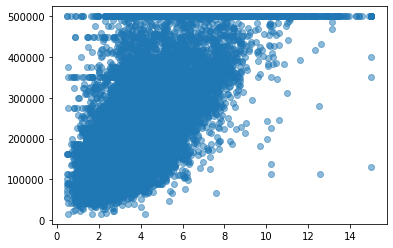

In [15]:
income_housevalue_plot = plt.scatter(median_income, median_house_value, alpha=0.5)

income_housevalue_plot

In [ ]:
columndrop_crimedata_2000 = 